## Tutorial 3: Creating a *scenario* from data

In this tutorial, we will cover the following items:

1. The data that is used to create the *scenario*
2. Fitting parameters of the *activities* based on the data
3. Plot the values of the state variable
4. Get value of state variable from activity
5. Fit parameters to get a smooth result

In [1]:
# Before starting, let us do the necessary imports
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from domain_model import Activity, ActivityCategory, Actor, ActorCategory, \
    Constant, Linear, PhysicalElement, PhysicalElementCategory, Scenario, Sinusoidal, \
    StateVariable, Spline3Knots, Splines, Tag, VehicleType

## 1. The data that is used to create the *scenario*

In this tutorial, we will create a *scenario* in which another vehicle changes lane such that it becomes the ego vehicle's leading vehicle. We have already seen this in [Tutorial 1](./Tutorial%201%20Scenario%20category.ipynb) and [Tutorial 2](./Tutorial%202%20Scenario.ipynb), where we created a *scenario category* and *scenario*, respectively. In this tutorial, however, we will demonstrate how a scenario can be created by using original data. The most important aspect of this tutorial is to see how the parameters of the *activities* can be fitted to the data.

The *scenario* is depicted in the figure below. Here, the blue car represents the ego vehicle and the red car represents the vehicle that performs the cut in.

<img src="./examples/images/cut-in.png" alt="Cut in" width="400"/>

The data is stored in a CSV file. It contains the following signals:

| Signal | Unit | Description |
|--|--|--|
| `v_ego` | m/s | Speed of the ego vehicle |
| `line_left` | m | Distance between the centre of the ego vehicle and its left lane line |
| `line_right` | m | Distance between the centre of the ego vehicle and its right lane line |
| `d_target` | m | Longitudinal distance between the target vehicle and the ego vehicle |
| `v_target` | m/s | Speed of the target vehicle |
| `line_left_target` | m | Distance between the centre of the target vehicle and the ego vehicle's left lane line |
| `line_right_target` | m | Distance between the centre of the target vehicle and the ego vehicle's right lane line |
| `act_lon_ego` | - | Longitudinal activity of the ego vehicle (a=accelerating, c=cruising, d=decelerating |
| `act_lat_ego` | - | Lateral activity of the ego vehicle (fl=following lane, l=changing lane left, r=changing lane right) |
| `act_lon_target` | - | Longitudinal activity of the ego vehicle (a=accelerating, c=cruising, d=decelerating |
| `act_lat_target` | - | Lateral activity of the ego vehicle (fl=following lane, li=left cut in, lo=left cut out, ri=right cut in, ro=right cut out)|

For more details on how the longitudinal and lateral activities of the ego vehicle and the target vehicle are determined, see [(de Gelder et al., 2020)](https://arxiv.org/abs/2006.00483).

Below, the first five rows of the data set are printed.

In [2]:
# Load the data.
DF = pd.read_csv(os.path.join("examples", "data_cutin_scenario.csv"), index_col=0)
DF.head()

,v_ego,line_left,line_right,d_target,v_target,act_lon_ego,act_lat_ego,line_left_target,line_right_target,act_lon_target,act_lat_target
0.00,28.038004,1.640564,-1.344018,69.910291,21.991694,c,fl,4.629250,1.644668,c,fl
0.01,28.063599,1.584440,-1.331774,69.829237,22.021166,c,fl,4.652119,1.735905,c,fl
0.02,28.046665,1.612872,-1.435880,69.791611,21.986155,c,fl,4.694873,1.646122,c,fl
0.03,28.062241,1.593595,-1.331668,69.683266,21.941585,c,fl,4.712076,1.786813,c,fl
0.04,28.152545,1.618981,-1.235281,69.743912,21.911208,c,fl,4.762200,1.907938,c,fl


In the figure below, the speed of the ego vehicle and the speed of the target vehicle are shown. The background color of the figure refers to the different longitudinal activities of the ego vehicle. As shown in the figure, the signals contain some noise.

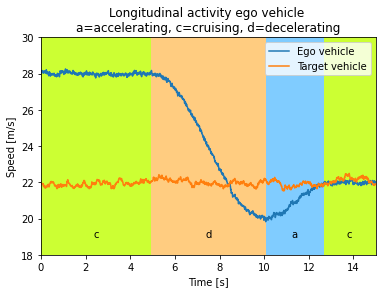

In [3]:
# Plot the speed of both the ego vehicle and the target vehicle
plt.plot(DF["v_ego"], label="Ego vehicle")
plt.plot(DF["v_target"], label="Target vehicle")
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.legend(loc="upper right")
XLIM = plt.xlim(0, DF.index[-1])
YLIM = plt.ylim(18, 30)

# Color the background to show the longitudinal activity of the ego vehicle.
I_EVENT_LON_EGO = DF.index[DF["act_lon_ego"] != DF["act_lon_ego"].shift()].to_list()
I_EVENT_LON_EGO.append(DF.index[-1])
COLORS = dict(a=(.5, .8, 1), c=(.8, 1, .2), d=(1, .8, .5))
for i_start, i_end in zip(I_EVENT_LON_EGO[:-1], I_EVENT_LON_EGO[1:]):
    plt.fill([i_start, i_end, i_end, i_start], [YLIM[0], YLIM[0], YLIM[1], YLIM[1]], 
             color=COLORS[DF.at[i_start, "act_lon_ego"]])
    plt.text((i_start+i_end)/2, 19, DF.at[i_start, "act_lon_ego"], horizontalAlignment="center")
plt.title("Longitudinal activity ego vehicle \na=accelerating, c=cruising, d=decelerating")
plt.show()

To detect the cut in of the target vehicle, the distance of the target vehicle towards the lane lines of the ego vehicle are used. 

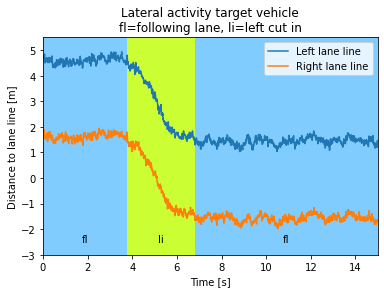

In [4]:
# Plot the distance of the target to the ego vehicles lane lines.
plt.plot(DF["line_left_target"], label="Left lane line")
plt.plot(DF["line_right_target"], label="Right lane line")
plt.xlabel("Time [s]")
plt.ylabel("Distance to lane line [m]")
plt.legend(loc="upper right")
XLIM = plt.xlim(0, DF.index[-1])
YLIM = plt.ylim(-3, 5.5)

# Color the background to show the lateral activity of the target vehicle.
I_EVENT_LAT_TARGET = DF.index[DF["act_lat_target"] != DF["act_lat_target"].shift()].to_list()
I_EVENT_LAT_TARGET.append(DF.index[-1])
COLORS = dict(fl=(.5, .8, 1), li=(.8, 1, .2))
for i_start, i_end in zip(I_EVENT_LAT_TARGET[:-1], I_EVENT_LAT_TARGET[1:]):
    plt.fill([i_start, i_end, i_end, i_start], [YLIM[0], YLIM[0], YLIM[1], YLIM[1]], 
             color=COLORS[DF.at[i_start, "act_lat_target"]])
    plt.text((i_start+i_end)/2, -2.5, DF.at[i_start, "act_lat_target"], horizontalAlignment="center")
plt.title("Lateral activity target vehicle\nfl=following lane, li=left cut in")
plt.show()

## 2 Fitting parameters of the *activities* based on the data

Before creating the *activities*, we need to create the *activity categories*. The *models* that are contained by the *activity categories* are used to fit the parameters.

In [5]:
# First create the activity categories
CRUISING_CATEGORY = ActivityCategory(
    Constant(), StateVariable.SPEED, name="Cruising",
    description="Cruising at a constant positive speed",
    tags=[Tag.VehicleLongitudinalActivity_DrivingForward_Cruising])
BRAKING_CATEGORY = ActivityCategory(
    Sinusoidal(), StateVariable.SPEED, name="Braking",
    description="Decelerating to a lower speed",
    tags=[Tag.VehicleLongitudinalActivity_DrivingForward_Braking])
ACCELERATING_CATEGORY = ActivityCategory(
    Splines(n_knots=1), StateVariable.SPEED, name="Acccelerating",
    description="Accelerating to a higher speed",
    tags=[Tag.VehicleLongitudinalActivity_DrivingForward_Accelerating])
FOLLOWING_LANE_CATEGORY = ActivityCategory(
    Linear(), StateVariable.LATERAL_POSITION, name="Following lane",
    description="Stay in one lane",
    tags=[Tag.VehicleLateralActivity_GoingStraight])
CHANGING_LANE_CATEGORY = ActivityCategory(
    Spline3Knots(), StateVariable.LATERAL_POSITION, name="Changing lane",
    description="Change one lane to the left or to the right",
    tags=[Tag.VehicleLateralActivity_ChangingLane])

### 2.1 Longitudinal activities of the ego vehicle

We will start with the decelerating activity of the ego vehicle. The first thing we need to do is to select the right data. For the decelerating activity, these are the rows in which the `act_lon_ego` has the value `d`. Since this is the second activity (see figure above), we can select the data that is between the time instants `I_EVENT_LON_EGO[1]` and `I_EVENT_LON_EGO[2]`.

To fit the data to the model, we use the `fit` function of the *activity category*. This, in turn, will call the `fit` function of the model that the *activity category* contains. The `fit` function takes two mandatory arguments. To learn more about this, simply use the `help` function.

In [6]:
help(BRAKING_CATEGORY.fit)

Help on method fit in module domain_model.activity_category:

fit(time: numpy.ndarray, data: numpy.ndarray, **kwargs) -> dict method of domain_model.activity_category.ActivityCategory instance
    Fit the data to the model and return the parameters.
    
    The data is to be fit to the model that is set for this ActivityCategory
    and the resulting parameters are returned in a dictionary. See the fit
    method from Model for more details.
    
    :param time: the time instants of the data.
    :param data: the data that will be fit to the model.
    :param kwargs: specify some model-specific options.
    :return: dictionary of the parameters.



It is possible to provide optional argument. Which optional arguments can be used depends on the model. If we want to learn more about the specific model that is used, we can use the `help` function for that specific model, e.g., `help(Linear)`.

We do not use the optional arguments, so we can obtain the parameters by passing the time and the speed data.

In [7]:
# Fit the braking activity of the ego vehicle.
TIME = DF.loc[I_EVENT_LON_EGO[1]:I_EVENT_LON_EGO[2]].index.to_list()
PARAMETERS = BRAKING_CATEGORY.fit(TIME, DF.loc[I_EVENT_LON_EGO[1]:I_EVENT_LON_EGO[2], "v_ego"].values)

# Create the braking activity.
BRAKING_EGO = Activity(BRAKING_CATEGORY, PARAMETERS, start=I_EVENT_LON_EGO[1], 
                       end=I_EVENT_LON_EGO[2], name="Braking ego")

To see how well the model fits the data, we can use the `get_state` function of the *activity*. As can be seen in the figure below, the model fits the data nicely.

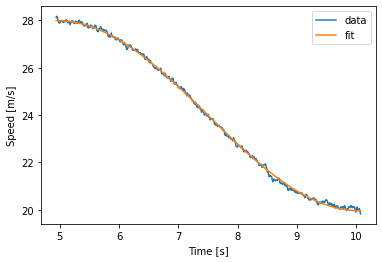

In [8]:
# Show the resulting fit.
plt.plot(DF.loc[I_EVENT_LON_EGO[1]:I_EVENT_LON_EGO[2], "v_ego"], label="data")
plt.plot(TIME, BRAKING_EGO.get_state(time=np.array(TIME)), label="fit")
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.legend()
plt.show()

There are three more longitudinal activities of the ego vehicle. We will create these activities in a similar manner.

In [9]:
# Fit the other longitudinal activities of the ego vehicle.
TIME = DF.loc[:I_EVENT_LON_EGO[1]].index.to_list()
PARAMETERS = CRUISING_CATEGORY.fit(TIME, DF.loc[:I_EVENT_LON_EGO[1], "v_ego"])
CRUISING_EGO1 = Activity(CRUISING_CATEGORY, PARAMETERS, start=I_EVENT_LON_EGO[0],
                         end=BRAKING_EGO.start, name="Initial cruising ego")
TIME = DF.loc[I_EVENT_LON_EGO[2]:I_EVENT_LON_EGO[3]].index.to_list()
PARAMETERS = ACCELERATING_CATEGORY.fit(TIME, DF.loc[I_EVENT_LON_EGO[2]:I_EVENT_LON_EGO[3], "v_ego"])
ACCELERATING_EGO = Activity(ACCELERATING_CATEGORY, PARAMETERS, start=BRAKING_EGO.end, 
                            end=I_EVENT_LON_EGO[3], name="Initial cruising ego")
TIME = DF.loc[I_EVENT_LON_EGO[3]:].index.to_list()
PARAMETERS = CRUISING_CATEGORY.fit(TIME, DF.loc[I_EVENT_LON_EGO[3]:, "v_ego"])
CRUISING_EGO2 = Activity(CRUISING_CATEGORY, PARAMETERS, start=ACCELERATING_EGO.end,
                         end=I_EVENT_LON_EGO[4], name="Final cruising ego")

### 2.2 Lateral activity of the ego vehicle

There is only one lateral activity of the ego vehicle as the ego vehicle does not change lane. We can fit the parameters with the same approach. Note that we assume that the center of the two-lane road is at the right lane line of the ego vehicle. 

In [10]:
# Create the activity that describes the lateral movement of the ego vehicle.
PARAMETERS = FOLLOWING_LANE_CATEGORY.fit(np.array(DF.index), -DF["line_right"].values)
STRAIGHT_EGO = Activity(FOLLOWING_LANE_CATEGORY, PARAMETERS,
                        start=CRUISING_EGO1.start, end=CRUISING_EGO2.end, name="Following lane ego")

### 2.3 Longitudinal activity of the target vehicle

There is only one longitudinal activity of the target vehicle. 

In [11]:
# Fit the longitudinal activity of the target vehicle.
PARAMETERS = CRUISING_CATEGORY.fit(np.array(DF.index), DF["v_target"].values)
CRUISING_TARGET = Activity(CRUISING_CATEGORY, PARAMETERS,
                           start=CRUISING_EGO1.start, end=CRUISING_EGO2.end)

### 2.4 Lateral activities of the target vehicle

There are three lateral activities of the target vehicle: Following lane, changing lane, and again following lane. A spline function is fitted to the data of the lane change.

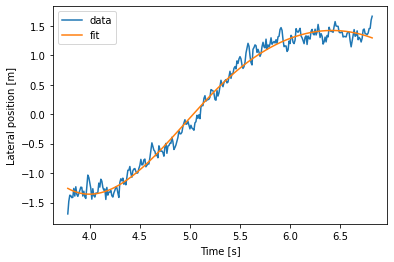

In [12]:
# Create activity that describes the lane change of the target vehicle.
Y_TARGET = -DF["line_right_target"]
TIME = np.array(DF.loc[I_EVENT_LAT_TARGET[1]:I_EVENT_LAT_TARGET[2]].index.to_list())
PARAMETERS = CHANGING_LANE_CATEGORY.fit(TIME, Y_TARGET[I_EVENT_LAT_TARGET[1]:I_EVENT_LAT_TARGET[2]])
LANE_CHANGE_TARGET = Activity(CHANGING_LANE_CATEGORY, PARAMETERS, start=I_EVENT_LAT_TARGET[1],
                              end=I_EVENT_LAT_TARGET[2], name="Lane change target",
                              tags=[Tag.VehicleLateralActivity_ChangingLane_Left])

# Show the resulting fit.
plt.plot(Y_TARGET[I_EVENT_LAT_TARGET[1]:I_EVENT_LAT_TARGET[2]], label="data")
plt.plot(TIME, LANE_CHANGE_TARGET.get_state(PARAMETERS, time=TIME), label="fit")
plt.xlabel("Time [s]")
plt.ylabel("Lateral position [m]")
plt.legend()
plt.show()

In [13]:
# Fit the other lateral activities of the target vehicle.
TIME = DF.loc[I_EVENT_LAT_TARGET[0]:I_EVENT_LAT_TARGET[1]].index.to_list()
PARAMETERS = FOLLOWING_LANE_CATEGORY.fit(TIME, Y_TARGET[:I_EVENT_LAT_TARGET[1]])
STRAIGHT_TARGET1 = Activity(FOLLOWING_LANE_CATEGORY, PARAMETERS,
                            start=CRUISING_EGO1.start, end=LANE_CHANGE_TARGET.start)
TIME = DF.loc[I_EVENT_LAT_TARGET[2]:I_EVENT_LAT_TARGET[3]].index.to_list()
PARAMETERS = FOLLOWING_LANE_CATEGORY.fit(TIME, Y_TARGET[I_EVENT_LAT_TARGET[2]:])
STRAIGHT_TARGET2 = Activity(FOLLOWING_LANE_CATEGORY, PARAMETERS,
                            start=LANE_CHANGE_TARGET.end, end=CRUISING_EGO2.end)

## 3 Plot the values of the state variable

Now that we have set the parameters for the activities, we can show the result. To do this, we can use the `plot` function of an *activity*. Any keyword arguments provided are passed to the underlying `plot` function of matplotlib. The `plot` function returns the axes of the plot. The axes can be used as input to the `plot` function as well, such that multiple activities can be plotted into one figure.

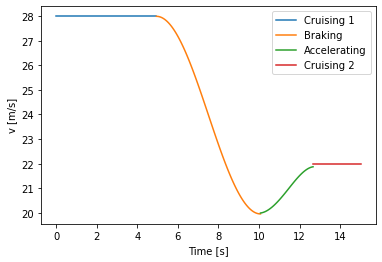

In [14]:
axes = CRUISING_EGO1.plot(label="Cruising 1")
BRAKING_EGO.plot(axes, label="Braking")
ACCELERATING_EGO.plot(axes, label="Accelerating")
CRUISING_EGO2.plot(axes, label="Cruising 2")
plt.legend()
plt.show()

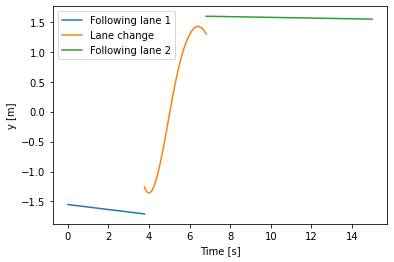

In [15]:
axes = STRAIGHT_TARGET1.plot(label="Following lane 1")
LANE_CHANGE_TARGET.plot(axes, label="Lane change")
STRAIGHT_TARGET2.plot(axes, label="Following lane 2")
plt.legend()
plt.show()

Note that there are discontinuities between the different activities. In other words, the values of the state variables 'jump' at the end of one activity to the start of another activity. Later in this tutorial, we will demonstrate two ways to avoid these jumps/discontinuities.

## 4 Get value of state variable from activity

To make the figures as shown above, the `plot` function of the activity calls its own `get_state` function. We can do that too. There are different way to call this function:

- By default, the function uses the argument `npoints=100`, which means that the values of 100 points are returned. These points are evenly spread in time.
- Using `time=<float>`, the value of the state variable at a certain time instant is returned.
- Similarly, if `time=<List[float]>`, the values of the state variable at the time instants listed in the provided list are returned.
- Instead of a list of floats, a numpy array can be passed (`time=<np.ndarray>`).

In [16]:
BRAKING_EGO.get_state(npoints=10)

array([27.99015477, 27.74796364, 27.05060209, 25.98218221, 24.6715712 ,
       23.27684809, 21.96623708, 20.8978172 , 20.20045565, 19.95826452])

In [17]:
BRAKING_EGO.get_state(time=8)

array([22.77539055])

In [18]:
BRAKING_EGO.get_state(time=[6, 7, 8, 9])

array([27.17332744, 25.19647827, 22.77539055, 20.79001855])

In [19]:
# Note that this gives the same result as with `npoints=10`
BRAKING_EGO.get_state(time=np.linspace(BRAKING_EGO.get_tstart(),
                                       BRAKING_EGO.get_tend(), 10))

array([27.99015477, 27.74796364, 27.05060209, 25.98218221, 24.6715712 ,
       23.27684809, 21.96623708, 20.8978172 , 20.20045565, 19.95826452])

## 5 Fit parameters to get a smooth result

As can be shown in the figure above, when returning the values of a state variable over the course of a scenario, it turns out that these values are not smooth, i.e., there are jumps. Here, we will present two approaches that can be used to get rid of those jumps.

The first approach is to make use of the `get_state` function of a *scenario*, as already shown in the [previous tutorial](./Tutorial%202%20Scenario.ipynb). By using the *scenario* instead of the individual activities, we can return the values of the state variable for the whole scenario. This, in turn, can be used to compare with the data. Let us first create the scenario:

In [20]:
# Create the actor categories.
EGO_VEHICLE_QUALITATIVE = ActorCategory(VehicleType.Vehicle, name="Ego vehicle", 
                                        tags=[Tag.EgoVehicle, Tag.RoadUserType_Vehicle])
TARGET_VEHICLE_QUALITATIVE = ActorCategory(VehicleType.Vehicle, name="Target vehicle",
                                           tags=[Tag.RoadUserType_Vehicle])

In [21]:
# Create the actors.
EGO_VEHICLE = Actor(EGO_VEHICLE_QUALITATIVE,
                    properties=dict(color="blue"),
                    name="ego vehicle")
TARGET_VEHICLE = Actor(TARGET_VEHICLE_QUALITATIVE,
                       properties=dict(color="red"),
                       name="target vehicle")

In [22]:
# Create the scenario.
CUTIN = Scenario(start=CRUISING_EGO1.start, end=CRUISING_EGO2.end, name="cut-in scenario")
CUTIN.set_actors([EGO_VEHICLE, TARGET_VEHICLE])
CUTIN.set_activities([CRUISING_EGO1, BRAKING_EGO, ACCELERATING_EGO, CRUISING_EGO2,
                      STRAIGHT_EGO, CRUISING_TARGET, 
                      STRAIGHT_TARGET1, LANE_CHANGE_TARGET, STRAIGHT_TARGET2])
CUTIN.set_acts([(EGO_VEHICLE, CRUISING_EGO1),
                (EGO_VEHICLE, BRAKING_EGO),
                (EGO_VEHICLE, ACCELERATING_EGO),
                (EGO_VEHICLE, CRUISING_EGO2),
                (EGO_VEHICLE, STRAIGHT_EGO),
                (TARGET_VEHICLE, CRUISING_TARGET),
                (TARGET_VEHICLE, STRAIGHT_TARGET1),
                (TARGET_VEHICLE, LANE_CHANGE_TARGET),
                (TARGET_VEHICLE, STRAIGHT_TARGET2)])

By minimizing the integrated squared error between the output the `get_state` function of the *scenario* and the data, we can find the parameters. To ensure smoothness, we limit the freedom of the parameters:

- The first activity is a cruising activity and it only has one parameter ($\theta_0$)
- The second activity is a decelerating activity and has two parameters, i.e., the values at the start and the end, respectively. To ensure smoothness between the first and the second parameter, the starting value of the braking activity needs to be equal to $\theta_0$. Let the end value be denoted by $\theta_1$.
- The third activity is an accelerating activity. This model uses b-splines of degree 3 with one interior knot. This spline model uses 5 parameters. To ensure a smooth transition from the second and the third activity, the first two parameters need to equal $\theta_1$. The third parameters can be chosen freely ($\theta_2$). The last two parameters need to be equal ($\theta_3$) in order to ensure a derivative of 0 and the end of the activity.
- The fourth activity is a cruising activity again. To make sure that the transition from the third and fourth activities is smooth, the one parameter of the cruising activity need to equal the last parameter of the spline model that is used for the accelerating activity ($\theta_3$). 

In total, we have four parameters. In the following code, a function is defined that takes as input these four parameters, sets the parameters of the activities accordingly, and returns the root mean squared error. Minimizing this error with respect to the four parameters gives our desired result.

In [23]:
def error_ego_speed(parameters):
    """ Return the RMSE of the ego speed.
    
    :param parameters: The four parameters that define the ego speed.
    :return: The resulting RMSE.
    """
    CRUISING_EGO1.parameters['xstart'] = parameters[0]
    BRAKING_EGO.parameters['xstart'] = parameters[0]
    BRAKING_EGO.parameters['xend'] = parameters[1]
    ACCELERATING_EGO.parameters['coefficients'][0:2] = parameters[1]
    ACCELERATING_EGO.parameters['coefficients'][2] = parameters[2]
    ACCELERATING_EGO.parameters['coefficients'][3:5] = parameters[3]
    CRUISING_EGO2.parameters['xstart'] = parameters[3]
    speed = CUTIN.get_state(EGO_VEHICLE, StateVariable.SPEED, DF.index.to_list())
    return np.sqrt(np.sum((speed - DF["v_ego"].values)**2) / len(DF["v_ego"]))

In [24]:
XINIT = [CRUISING_EGO1.parameters['xstart'], 
         BRAKING_EGO.parameters['xend'],
         ACCELERATING_EGO.parameters['coefficients'][2],
         CRUISING_EGO2.parameters['xstart']]

In [25]:
result = minimize(error_ego_speed, XINIT)
print(result.x)
print("Residual RMSE: {:.3f}".format(error_ego_speed(result.x)))

[27.99010134 19.97681984 20.78850795 21.95728724]
Residual RMSE: 0.084


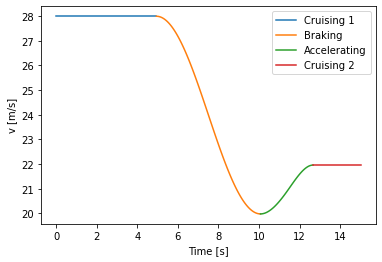

In [26]:
axes = CRUISING_EGO1.plot(label="Cruising 1")
BRAKING_EGO.plot(axes, label="Braking")
ACCELERATING_EGO.plot(axes, label="Accelerating")
CRUISING_EGO2.plot(axes, label="Cruising 2")
plt.legend()
plt.show()

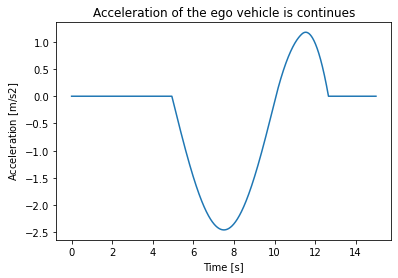

In [27]:
# Also show that the acceleration is continues.
plt.plot(DF.index, CUTIN.get_state_dot(EGO_VEHICLE, StateVariable.SPEED, list(DF.index)))
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [m/s$2$]")
plt.title("Acceleration of the ego vehicle is continues")
plt.show()

The second option to ensure that the values of the state variables of consecutive activities are continues it so fix the endpoints. Both the models *Linear* and *Spline3Knots* provide this option by using the optional argument `endpoints=True`. This forces the parameters such that the model exactly fits the data at the endpoints. Note that while this might be simpler because now the parameters of the activities can be fitted independently, it will generally not lead to the lowest mean squared error possible.

In [28]:
TIME = DF.loc[I_EVENT_LAT_TARGET[0]:I_EVENT_LAT_TARGET[1]].index.to_list()
STRAIGHT_TARGET1.parameters = FOLLOWING_LANE_CATEGORY.fit(
    TIME, Y_TARGET[:I_EVENT_LAT_TARGET[1]].values, endpoints=True)
TIME = np.array(DF.loc[I_EVENT_LAT_TARGET[1]:I_EVENT_LAT_TARGET[2]].index.to_list())
LANE_CHANGE_TARGET.parameters = CHANGING_LANE_CATEGORY.fit(
    TIME, Y_TARGET[I_EVENT_LAT_TARGET[1]:I_EVENT_LAT_TARGET[2]].values, endpoints=True)
TIME = DF.loc[I_EVENT_LAT_TARGET[2]:I_EVENT_LAT_TARGET[3]].index.to_list()
STRAIGHT_TARGET2.parameters = FOLLOWING_LANE_CATEGORY.fit(
    TIME, Y_TARGET[I_EVENT_LAT_TARGET[2]:].values, endpoints=True)

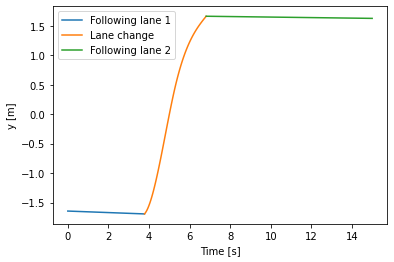

In [29]:
# Show that the resulting activities better fit to each other.
axes = STRAIGHT_TARGET1.plot(label="Following lane 1")
LANE_CHANGE_TARGET.plot(axes, label="Lane change")
STRAIGHT_TARGET2.plot(axes, label="Following lane 2")
plt.legend()
plt.show()

You reached the end of the third tutorial. In the [next tutorial](./Tutorial%204%20Scenario%20database.ipynb), we will see how we can use the domain model as a template for a scenario database.